In [17]:
import tensorflow as tf
import numpy as np
seed = 123
np.random.seed(seed)
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
from keras.applications import VGG16
import itertools
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sn
import fmnist_utils1

In [18]:
import tensorflow as tf
import os
from keras.backend.tensorflow_backend import set_session
os.environ["CUDA_VISIBLE_DEVICES"]="0"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9

set_session(tf.Session(config=config))

In [19]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')



#z-score
mean = np.mean(x_train,axis=(0,1))
std = np.std(x_train,axis=(0,1))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

datagen = ImageDataGenerator(
          featurewise_center=False,            # set input mean to 0 over the dataset
          samplewise_center=False,             # set each sample mean to 0
          featurewise_std_normalization=False, # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,                 # apply ZCA whitening
          rotation_range=30,                   # randomly rotate images in the range (degrees, 0 to 180)
          zoom_range = 0.1,                    # Randomly zoom image 
          width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
          horizontal_flip=False,               # randomly flip images
          vertical_flip=False)                 # randomly flip images

#datagen.fit(xtrain)
nclasses = 10
baseMapNum = 32
base_epochs = 10
weight_decay = 1e-4
dim = 28
image_shape = x_train.shape[1:]
epochs = 15
batch_size = 100
class_names = ['other', 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [20]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [28]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras import regularizers, optimizers
from keras.applications import VGG16
from keras.utils import np_utils
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

def data_split(n_classes, data, labels, seed=123, other_base=1):
    np.random.seed(seed)

    # python pass parameters as reference, it's better to make a copy here
    labels_copy = np.copy(labels)
    
#     other_base = 6 - n_classes
    
    if n_classes < 2:
        raise ValueError('n_classes must be between 2 and 10')

    # indices of classes that are not part of the 'other' class
    class_indices = np.argwhere(labels_copy < (n_classes - 1))[:,0]
    
    num_of_each_class = class_indices.shape[0]//(n_classes-1)

    # draw sample from 'other' class
    other_indices = np.random.choice(np.argwhere(labels_copy >= (n_classes + other_base - 1))[:,0], num_of_each_class, replace=False)

    # combine indices os the selected classs and the 'other' class
    all_indices = np.concatenate((class_indices, other_indices))

    # create new train and test datasets and labels
    selected_data = data[all_indices, :]
    selected_labels = labels_copy[all_indices]  #deep copy

    # adjust label of 'other' class: set to n_classes - 1, i.e. if we have two classes, cats and other, than cats will
    # have 0 and other will have 1
    selected_labels[selected_labels >= (n_classes - 1)] = n_classes - 1
    
    return (selected_data, selected_labels)

def generate_data(cur_target_class_ids, full_target_class_ids, data, labels, refining, seed=123):
    
    np.random.seed(seed)
    
    num_of_each_class = 5000
    
    n_final_classes_including_other = 10
    full_class_ids = np.arange(1, n_final_classes_including_other+1)
    
    if refining == True:
        other_class_ids = np.setxor1d(full_class_ids, cur_target_class_ids)
    else:
        other_class_ids = np.setxor1d(full_class_ids, full_target_class_ids)

    labels_copy = np.copy(labels)
    
    target_class_indices = np.array([], dtype='int32')
    for class_id in cur_target_class_ids:
            target_class_indices = np.append(target_class_indices, np.argwhere(labels_copy == class_id-1)[:,0])
    # TODO: temp code
    np.random.shuffle(target_class_indices)
    print(target_class_indices[:10])
    #labels_copy = labels_copy.reshape(60000,1)
    # create new train and test datasets and labels
    target_class_data = data[target_class_indices, :]
    target_class_labels = np.squeeze(labels_copy[target_class_indices, :])
    target_class_labels_copy = np.copy(target_class_labels)
    
    # Reasign the index of target-classes, starting from 1
    for i, class_id in enumerate(cur_target_class_ids):
        target_class_labels[np.argwhere(target_class_labels_copy == class_id-1)[:, 0]] = i+1
        
    # Other-class
    all_other_class_indices = np.array([], dtype='int32')
    for class_id in other_class_ids:
        if class_id == other_class_ids[0]: #TODO
            all_other_class_indices = np.append(all_other_class_indices, np.argwhere(labels_copy == class_id-1)[:,0])
    
    print('current other class: ' + str(other_class_ids))
    print('current target class: ' + str(cur_target_class_ids))
    print('all target target class: ' + str(full_target_class_ids))
    print('all class: ' + str(full_class_ids))
    print('all other class indices: ' + str(len(all_other_class_indices)))
    other_class_indices = np.random.choice(all_other_class_indices, num_of_each_class)
    
    other_class_data = data[other_class_indices, :]
    
    # set 'other' label to zero
    other_class_labels = np.array([0]*num_of_each_class)
    
    print(target_class_labels.shape, other_class_labels.shape)
    
    selected_data = np.concatenate((target_class_data, other_class_data))
    selected_labels = np.concatenate((target_class_labels, other_class_labels))
    
    return (selected_data, selected_labels)


def create_base_model(input_shape, baseMapNum = 32, weight_decay = 1e-4, net_type='kaggle'):
    '''net_type: 1. kaggle 2. VGG16'''
    model = Sequential()
    if net_type == 'kaggle':
        model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), 
                         input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
#         model.add(Dropout(0.2))

        model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
#         model.add(Dropout(0.3))

        model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
#         model.add(Dropout(0.4))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
#         model.add(Dropout(0.3))
        
        model.add(Dense(512, activation='relu'))
#         model.add(Dropout(0.3))
        #model.add(Dense(10, activation='softmax'))
    
    elif net_type == 'VGG16':   # not feasiable for cifar10 -- input size too small
        vgg16_net = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)
        model.add(vgg16_net)
    else:
        raise ValueError('unknown base net type')
    return model



def training(model, num_classes_including_other, train_data, train_labels, data_generator, batch_size, epochs):
    
    y_train_categorical = np_utils.to_categorical(train_labels, num_classes_including_other)
    
    opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    training_log_ep75 = model.fit(train_data, y_train_categorical, batch_size=batch_size,epochs=3*epochs, verbose=1, shuffle=False)
    
    opt_rms = keras.optimizers.rmsprop(lr=0.0005,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    training_log_ep100 = model.fit(train_data, y_train_categorical, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=False)

    opt_rms = keras.optimizers.rmsprop(lr=0.0003,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    training_log_ep125 = model.fit(train_data, y_train_categorical, batch_size=batch_size,epochs=epochs, verbose=1, shuffle=False)
    
    return 0

def tuning(model, num_classes_including_other, train_data, train_labels, data_generator, batch_size, epochs):
    
    y_train_categorical = np_utils.to_categorical(train_labels, num_classes_including_other)

    opt_rms = keras.optimizers.rmsprop(lr=0.0003,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    training_log_ep125 = model.fit_generator(
                                    data_generator.flow(train_data, y_train_categorical, batch_size=batch_size),
                                    steps_per_epoch=train_data.shape[0] // batch_size,epochs=epochs, verbose=1)
     

def evaluate(model, cur_target_class_ids,test_data, test_labels, batch_size):
    acc = []
    loss = []
    confusion_mtx = []
    num_classes = len(cur_target_class_ids)+1
    for i, class_id in enumerate(cur_target_class_ids):
        print(i,class_id)
        target_class_indices = np.argwhere(test_labels==class_id-1)[:, 0]
        target_test_data = test_data[target_class_indices]
#         print(len(target_test_data))
        target_test_labels = np.array([i+1]*target_test_data.shape[0])
        target_test_labels_categorical = np_utils.to_categorical(target_test_labels, num_classes)
        scores = model.evaluate(target_test_data, target_test_labels_categorical, batch_size, verbose=0)
        loss += [scores[0]]
        acc += [scores[1]]
        y_pred_categorical = model.predict(target_test_data)
        y_pred = np.argmax(y_pred_categorical, axis=1)
        print('y_sum ' + str(np.sum(y_pred)))
        unique, counts = np.unique(y_pred, return_counts=True)
        xor_result = np.setxor1d(unique, np.arange(0, num_classes))
        if len(xor_result) != 0:
            y_pred = np.concatenate((y_pred, xor_result))
            unique, counts = np.unique(y_pred, return_counts=True) 
        counts[0] = class_id  # set the first column to the class_id
        if len(counts) != num_classes:
            raise ValueError('TODO: handle dim exception: (%d, %d) ' %(len(counts), num_classes)) 
        confusion_mtx.append(counts.tolist())
    return acc, loss, np.array(confusion_mtx)

def plot_confusion_mtx(confusion_mtx, class_names):
    n_classes = len(confusion_mtx)
    class_ids = confusion_mtx[:, 0]
    df_cm = pd.DataFrame(confusion_mtx[:, 1:], index = [class_names[i] for i in class_ids] ,
                  columns =[class_names[i] for i in class_ids])
    plt.figure()
    sn.heatmap(df_cm, annot=True, cmap='summer')
    plt.show()
    return 

def training_with_GC(model, full_target_class_ids, epochs, x_train, y_train, x_test, y_test, data_generator, batch_size, refining):
    acc_GC = []
    loss_GC = []
    for i in range(len(full_target_class_ids)): # exclusive 'other'
        cur_target_class_ids = full_target_class_ids[:i+1]
        if(i >= 1):
            print('-----Adding a new class (total classes including other: %s)------' % str(i+2))
            for layer in model.layers:
                layer.trainable=False    
        model.add(Dense(i+2, activation='softmax'))
        (cur_train_data, cur_train_labels) = generate_data(cur_target_class_ids, full_target_class_ids, 
                                                           x_train, y_train, refining)
        data_generator.fit(cur_train_data)
        training(model, i+2, cur_train_data, cur_train_labels, data_generator, batch_size, epochs)
        print('-----Fine Tuning------')
        for layer in model.layers[-3:-1]:
            layer.trainable = True
        tuning(model, i+2, cur_train_data, cur_train_labels, data_generator, batch_size, epochs)
        # set back to untrainable
        for layer in model.layers[-3:-1]:
            layer.trainable = False
        acc, loss, confusion_mtx = evaluate(model, cur_target_class_ids, x_test, y_test, 100)
        acc_GC += [acc]
        loss_GC += [loss]
        model.pop()
        # plot confusion mtx
    return acc_GC, loss_GC

def plot_result(acc_all_class_from_scratch, acc_GC, acc_GC_refining, full_target_class_ids, class_names):
    
    def get_leading_zeros(arr):
        n_leading_zeros = 0
        for eli in arr:
            if eli != 0:
                break
            else:
                n_leading_zeros += 1
        return n_leading_zeros
    
    
    num_classes = len(full_target_class_ids)
    
    acc_GC_for_each_class = np.zeros((num_classes, num_classes))
    
    for i in range(num_classes):
        for j in range(len(acc_GC[i])):
            acc_GC_for_each_class[j][i] = acc_GC[i][j]
            
    acc_GC_refining_for_each_class = np.zeros((num_classes, num_classes))
    
    for i in range(num_classes):
        for j in range(len(acc_GC_refining[i])):
            acc_GC_refining_for_each_class[j][i] = acc_GC_refining[i][j]
    
    num_logs_for_each_class = np.arange(num_classes, 0, -1)
    acc_GC_avg_for_each_class = np.sum(acc_GC_for_each_class, axis=1)/num_logs_for_each_class
    acc_GC_refining_avg_for_each_class = np.sum(acc_GC_refining_for_each_class, axis=1)/num_logs_for_each_class

    for i in range(num_classes):
        n_leading_zeros = get_leading_zeros(acc_GC_refining_for_each_class[i])
        l = len(acc_GC_refining_for_each_class[i])
        plt.plot(np.arange(n_leading_zeros, l), acc_GC_for_each_class[i][n_leading_zeros:], label='Growing Classifier', marker='^')
        plt.plot(np.arange(n_leading_zeros, l), acc_GC_refining_for_each_class[i][n_leading_zeros:], label='Growing Classifier (Refining)', marker='^')
        plt.plot(np.arange(len(acc_GC_refining_for_each_class[i])), [acc_all_class_from_scratch[i]]*l, label='Train From Scratch', marker='^')
        plt.legend()
        plt.xlabel('num classes')
        plt.ylabel('accuracy')
        plt.title(class_names[full_target_class_ids[i]])
        plt.show()

        
#     print(acc_GC_for_each_class)

    for i in range(num_classes):
        n_leading_zeros = get_leading_zeros(acc_GC_for_each_class[i])
        l = len(acc_GC_for_each_class[i])
        plt.plot(np.arange(n_leading_zeros, l), acc_GC_for_each_class[i][n_leading_zeros:], label=class_names[full_target_class_ids[i]], marker='^')
    plt.legend()
    plt.xlabel('num classes')
    plt.ylabel('accuracy')
    plt.title('GC on all classes (No Refining)')
    plt.show()

    for i in range(num_classes):
        n_leading_zeros = get_leading_zeros(acc_GC_refining_for_each_class[i])
        l = len(acc_GC_refining_for_each_class[i])
        plt.plot(np.arange(n_leading_zeros, l), acc_GC_refining_for_each_class[i][n_leading_zeros:], label=class_names[full_target_class_ids[i]], marker='^')
    plt.legend()
    plt.xlabel('num classes')
    plt.ylabel('accuracy')
    plt.title('GC on all classes (Refining)')
    plt.show()

    plt.plot(np.arange(num_classes), acc_GC_avg_for_each_class, label='Growing Classifer', marker='^')
    plt.plot(np.arange(num_classes), acc_GC_refining_avg_for_each_class, label='Growing Classifer (Refining)', marker='^')
    plt.plot(np.arange(num_classes), acc_all_class_from_scratch, label='train from scratch', marker='^')
    plt.legend()
    plt.xlabel('class ID ' + str([class_names[el] for el in full_target_class_ids]))
    plt.ylabel('accuracy')
    plt.title('GC (with and without refining) v.s. Train from scratch')
    plt.show()
    
    return


# General Procedure
def one_run1(model, x_train, y_train, x_test, y_test, batch_size, full_target_class_ids,base_epochs,class_names,initial_weights,datagen):
    seed=123
#     np.random.seed(seed)
    num_classes_excluding_other = len(full_target_class_ids)
    num_classes_including_other = num_classes_excluding_other + 1


    
    ### Train From Scratch ###
    print('\n======Training From Scratch=========\n')
#     weights_train_from_scratch = list(initial_weights)
    # use the same initial weights
    model.set_weights(initial_weights)
    for layer in model.layers:
        layer.trainable = True
    model.add(Dense(num_classes_including_other, activation='softmax'))

    # in train-from-scratch, feed all target class at the begining, 
    # i.e., cur_target_class_ids is same with full_target_class_ids
    cur_target_class_ids = np.copy(full_target_class_ids)

    (cur_train_data, cur_train_labels) = generate_data(cur_target_class_ids, full_target_class_ids, x_train, y_train, False, seed)
    datagen.fit(cur_train_data)
    training(model, num_classes_including_other, cur_train_data, cur_train_labels, 
                           datagen, batch_size, base_epochs)
#    training(model, num_classes_including_other, x_train, y_train, datagen, batch_size, base_epochs)

    acc_all_class_from_scratch, loss_all_class_from_scratch, scratch_confusion_mtx = evaluate(model, cur_target_class_ids, 
                                                                       x_test, y_test, batch_size)
    #remove the last layer
    model.pop()
    
    print("acc all class from scratch",acc_all_class_from_scratch)
    plot_confusion_mtx(scratch_confusion_mtx, class_names)
        ### Growing Classifier (Refining) ###
    print('\n=====Training Using Growing Classifier (new classes appeared in \'Other\' class before) ======\n')
    weights_growing_classifier_refining = list(initial_weights)
    # use the same initial weights
    model.set_weights(weights_growing_classifier_refining)
    for layer in model.layers: layer.trainable = True

    acc_GC_refining, loss_GC_refining = training_with_GC(model, full_target_class_ids, base_epochs, 
                                                         x_train, y_train, x_test, y_test,datagen, batch_size, True)
    print("accuracy GC refining",acc_GC_refining)
    #     ### Growing Classifier ###

    #plot_result(acc_all_class_from_scratch, acc_GC, acc_GC_refining, full_target_class_ids, class_names)

    return acc_all_class_from_scratch,acc_GC_refining
# General Procedure
def one_run(model, x_train, y_train, x_test, y_test, batch_size, full_target_class_ids, initial_weights, base_epochs, datagen, class_names, seed=123):
    
#     np.random.seed(seed)
    num_classes_excluding_other = len(full_target_class_ids)
    num_classes_including_other = num_classes_excluding_other + 1


    
    ### Train From Scratch ###
    print('\n======Training From Scratch=========\n')
#     weights_train_from_scratch = list(initial_weights)
    # use the same initial weights
    #model.set_weights(initial_weights)
#     for layer in model.layers:
#         layer.trainable = True
#     model.add(Dense(num_classes_including_other, activation='softmax'))

    # in train-from-scratch, feed all target class at the begining, 
    # i.e., cur_target_class_ids is same with full_target_class_ids
    cur_target_class_ids = np.copy(full_target_class_ids)

#     (cur_train_data, cur_train_labels) = generate_data(cur_target_class_ids, full_target_class_ids, 
#                                                                x_train, y_train, False, seed)

#     datagen.fit(cur_train_data)

#     training(model, num_classes_including_other, cur_train_data, cur_train_labels, 
#                            datagen, batch_size, base_epochs)
    training(model, num_classes_including_other, x_train, y_train, datagen, batch_size, base_epochs)

    acc_all_class_from_scratch, loss_all_class_from_scratch, scratch_confusion_mtx = evaluate(model, cur_target_class_ids, 
                                                                       x_test, y_test, batch_size)
    # remove the last layer
#     model.pop()
    
    print(acc_all_class_from_scratch)
    plot_confusion_mtx(scratch_confusion_mtx, class_names)
    
    ### Growing Classifier (Refining) ###
#     print('\n=====Training Using Growing Classifier (new classes appeared in \'Other\' class before) ======\n')
#     weights_growing_classifier_refining = list(initial_weights)
#     # use the same initial weights
#     model.set_weights(weights_growing_classifier_refining)
#     for layer in model.layers: layer.trainable = True

#     acc_GC_refining, loss_GC_refining = training_with_GC(model, full_target_class_ids, base_epochs, 
#                                                          x_train, y_train, x_test, y_test, 
#                                                                        datagen, batch_size, True)

#     ### Growing Classifier ###
#     print('\n=====Training Using Growing Classifier (new classes never appeared in \'Other\' class before) ======\n')
#     weights_growing_classifier = list(initial_weights)
#     # use the same initial weights
#     model.set_weights(weights_growing_classifier)

#     for layer in model.layers: layer.trainable = True

#     acc_GC, loss_GC = training_with_GC(model, full_target_class_ids, base_epochs, 
#                                                     x_train, y_train, x_test, y_test, 
#                                                      datagen, batch_size, False)
    
#     plot_result(acc_all_class_from_scratch, acc_GC, acc_GC_refining, full_target_class_ids, class_names)
     #
    return acc_all_class_from_scratch
def one_run2(model, x_train, y_train, x_test, y_test, batch_size, full_target_class_ids,base_epochs,class_names,initial_weights):
    seed=123
#     np.random.seed(seed)
    num_classes_excluding_other = len(full_target_class_ids)
    num_classes_including_other = num_classes_excluding_other + 1


    
    ### Train From Scratch ###
    print('\n======Training From Scratch=========\n')
    weights_train_from_scratch = list(initial_weights)
    # use the same initial weights
    model.set_weights(initial_weights)
    for layer in model.layers:
        layer.trainable = True
    model.add(Dense(num_classes_including_other, activation='softmax'))

    # in train-from-scratch, feed all target class at the begining, 
    # i.e., cur_target_class_ids is same with full_target_class_ids
    cur_target_class_ids = np.copy(full_target_class_ids)

    (cur_train_data, cur_train_labels) = generate_data(cur_target_class_ids, full_target_class_ids, x_train, y_train, False, seed)
    datagen.fit(cur_train_data)
    training(model, num_classes_including_other, cur_train_data, cur_train_labels, 
                           datagen, batch_size, base_epochs)
#    training(model, num_classes_including_other, x_train, y_train, datagen, batch_size, base_epochs)

    acc_all_class_from_scratch, loss_all_class_from_scratch, scratch_confusion_mtx = evaluate(model, cur_target_class_ids, 
                                                                       x_test, y_test, batch_size)
    #remove the last layer
    model.pop()
    
    print(acc_all_class_from_scratch)
    plot_confusion_mtx(scratch_confusion_mtx, class_names)
        ### Growing Classifier (Refining) ###
    print('\n=====Training Using Growing Classifier (new classes appeared in \'Other\' class before) ======\n')
    #weights_growing_classifier_refining = list(initial_weights)
    # use the same initial weights
    #model.set_weights(weights_growing_classifier_refining)
    #for layer in model.layers: layer.trainable = True

    #acc_GC_refining, loss_GC_refining = training_with_GC(model, full_target_class_ids, base_epochs, 
    #                                                     x_train, y_train, x_test, y_test,datagen, batch_size, True)
    
    #     ### Growing Classifier ###
    #print('\n=====Training Using Growing Classifier (new classes never appeared in \'Other\' class before) ======\n')
    #weights_growing_classifier = list(initial_weights)
     # use the same initial weights
#     model.set_weights(weights_growing_classifier)

    #for layer in model.layers: layer.trainable = True

    #acc_GC, loss_GC = training_with_GC(model, full_target_class_ids, base_epochs, 
    #                                                x_train, y_train, x_test, y_test, 
    #                                                 datagen, batch_size, False)
    

    #plot_result(acc_all_class_from_scratch, acc_GC, acc_GC_refining, full_target_class_ids, class_names)

    return acc_all_class_from_scratch

In [22]:
model = create_base_model(image_shape, baseMapNum, weight_decay, 'kaggle')
model.summary()
initial_weights = model.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [23]:
print('===============BASELINE Results On All Classes===========')

num_classes_excluding_other = 9
full_class_ids = np.arange(1, 11)  # 1-10
#np.random.shuffle(full_class_ids)
#full_target_class_ids = full_class_ids[:num_classes_excluding_other]
#full_target_class_ids =[1,2,3,4,5,6,7,9,10]
full_target_class_ids =[1,9,10,2,4,6,3,7,5]

===============BASELINE Results On All Classes===========


In [24]:
cur_target_class_ids = np.copy(full_target_class_ids)
print(cur_target_class_ids)

[ 1  9 10  2  4  6  3  7  5]


In [25]:
cur_target_class_ids = np.copy(full_target_class_ids)

(cur_train_data, cur_train_labels) = generate_data(cur_target_class_ids, full_target_class_ids, x_train, y_train, False, seed)
datagen.fit(cur_train_data)

[22802 28854  3874 46851 15338 14832 43962 22769  9625 42717]
current other class: [8]
current target class: [ 1  9 10  2  4  6  3  7  5]
all target target class: [1, 9, 10, 2, 4, 6, 3, 7, 5]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 5000
(45000,) (5000,)


In [26]:
#full_target_class_ids = full_class_ids[:num_classes_excluding_other]
selected_class_names = [class_names[el] for el in full_target_class_ids]
print('selected classes: ' + str(selected_class_names))

cur_target_class_ids = np.copy(full_target_class_ids)

n_running_instance = 3


selected classes: ['airplane', 'ship', 'truck', 'automobile', 'cat', 'dog', 'bird', 'frog', 'deer']


In [11]:
baseline_results = []
for i in range(n_running_instance):
    print('Running Instance ' + str(i) + ': ')
    baseline_result = one_run2(model, x_train, y_train, x_test, y_test, batch_size,full_target_class_ids, base_epochs, class_names,initial_weights)
    baseline_results += [baseline_result]
baseline_results = np.array(baseline_results)

Running Instance 0: 

======Training From Scratch=========

[22802 28854  3874 46851 15338 14832 43962 22769  9625 42717]
current other class: [8]
current target class: [ 1  9 10  2  4  6  3  7  5]
all target target class: [1, 9, 10, 2, 4, 6, 3, 7, 5]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 5000
(45000,) (5000,)
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
17200/50000 [=========>....................] - ETA: 10s - loss: 1.8886 - acc: 0.4158

KeyboardInterrupt: 

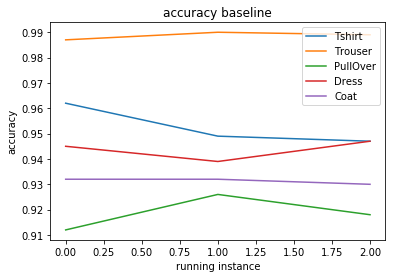

In [14]:
for i, class_name in enumerate(class_names):
    plt.plot(np.arange(n_running_instance), baseline_results[:, i], label=class_name)
plt.title('accuracy baseline')
plt.xlabel('running instance')
plt.ylabel('accuracy')
plt.legend()
plt.show()

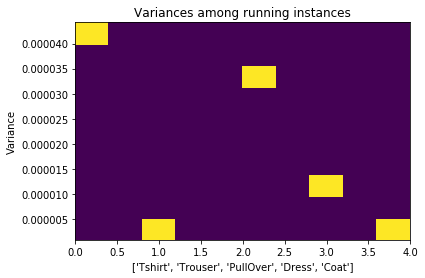

In [15]:
# variance for each class among running instances
baseline_results_var = np.var(baseline_results, axis=0)
# plot variances of each class on different instances
plt.hist2d(range(len(class_names)), baseline_results_var)
plt.title('Variances among running instances')
plt.xlabel(str(class_names))
plt.ylabel('Variance')
plt.show()

In [8]:
num_classes_excluding_other = 9
base_epochs = 10
full_class_ids = np.arange(1, 11) 
full_target_class_ids = full_class_ids[:num_classes_excluding_other]
#full_target_class_ids = np.array([1,2,3,4,5,6,7,8,9])
selected_class_names = [class_names[el] for el in full_target_class_ids]
print('selected classes: ' + str(selected_class_names))



selected classes: ['Tshirt', 'Trouser', 'PullOver', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag']


In [9]:
#full_target_class_ids_all_permutation = list(itertools.permutations(full_target_class_ids))

cur_target_class_ids = np.copy(full_target_class_ids)

GC_refining_results = []
GC_results = []
from_scratch_results = []
from_scratch_result= one_run1(model, x_train, y_train,
                                       x_test, y_test, batch_size, full_target_class_ids,
                                       base_epochs, class_names,initial_weights,datagen)
from_scratch_results += [from_scratch_result]


======Training From Scratch=========

[33057 10576 24450 47994 25516 54761 36685 50160 44672 30282]
current other class: [ 5  6  7  8  9 10]
current target class: [1 2 3 4]
all target target class: [1 2 3 4]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 6000
(24000,) (6000,)
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
30000/30000 [==============================] - 6s 190us/step - loss: 0.9917 - acc: 0.6504
Epoch 2/10
30000/30000 [==============================] - 3s 109us/step - loss: 0.8889 - acc: 0.8015
Epoch 3/10
30000/30000 [==============================] - 3s 109us/step - loss: 0.6759 - acc: 0.8624
Epoch 4/10
 5120/30000 [====>.........................] - ETA: 2s - loss: 1.6629 - acc: 0.6896

KeyboardInterrupt: 

In [9]:
print('sequence of class addition: ' + str([class_names[el] for el in full_target_class_ids]))

sequence of class addition: ['Tshirt', 'Trouser', 'PullOver', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag']


In [39]:
from_scratch_result, GC_refining_result, GC_result = one_run1(model, x_train, y_train, 
                                            x_test, y_test, batch_size, full_target_class_ids, 
                                              base_epochs, class_names)

TypeError: one_run1() missing 2 required positional arguments: 'initial_weights' and 'datagen'


======Training From Scratch=========

[22215 28854  4332 47596 15543 15299 43962 22769  9778 42888]
current other class: [10]
current target class: [1 2 3 4 5 6 7 8 9]
all target target class: [1 2 3 4 5 6 7 8 9]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 5000
(45000,) (5000,)
Epoch 1/30
50000/50000 [==============================] - 16s 327us/step - loss: 1.3528 - acc: 0.5736
Epoch 2/30
50000/50000 [==============================] - 12s 244us/step - loss: 0.8370 - acc: 0.7421
Epoch 3/30
50000/50000 [==============================] - 12s 243us/step - loss: 0.6594 - acc: 0.8054
Epoch 4/30
50000/50000 [==============================] - 12s 243us/step - loss: 0.5598 - acc: 0.8454
Epoch 5/30
50000/50000 [==============================] - 12s 244us/step - loss: 0.4894 - acc: 0.8719
Epoch 6/30
50000/50000 [==============================] - 12s 244us/step - loss: 0.4426 - acc: 0.8915
Epoch 7/30
50000/50000 [==============================] - 12s 243us/step - loss: 0.3

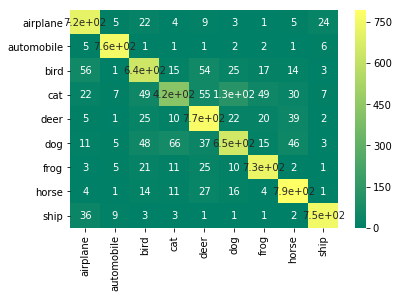


=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

[26493 24679 45393 48729   905 40542   352 17396 16952 22951]
current other class: [ 2  3  4  5  6  7  8  9 10]
current target class: [1]
all target target class: [1 2 3 4 5 6 7 8 9]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 5000
(5000,) (5000,)
Epoch 1/30
10000/10000 [==============================] - 7s 674us/step - loss: 8.1004 - acc: 0.4943
Epoch 2/30
10000/10000 [==============================] - 2s 234us/step - loss: 3.5265 - acc: 0.7765
Epoch 3/30
10000/10000 [==============================] - 2s 234us/step - loss: 0.5311 - acc: 0.9556
Epoch 4/30
10000/10000 [==============================] - 2s 233us/step - loss: 0.4559 - acc: 0.9631
Epoch 5/30
10000/10000 [==============================] - 2s 233us/step - loss: 0.4034 - acc: 0.9648
Epoch 6/30
10000/10000 [==============================] - 2s 234us/step - loss: 0.3256 - acc: 0.9720
Epoch 7/30
10000/10000 [===

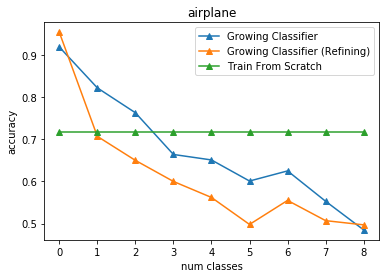

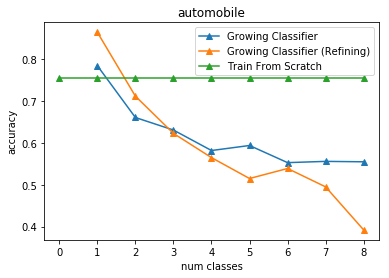

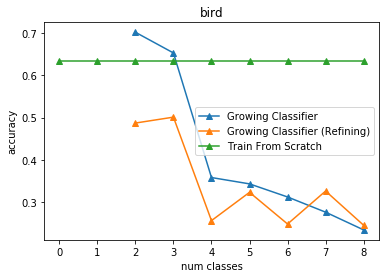

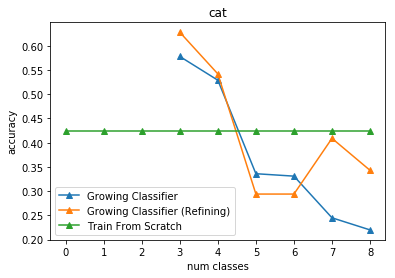

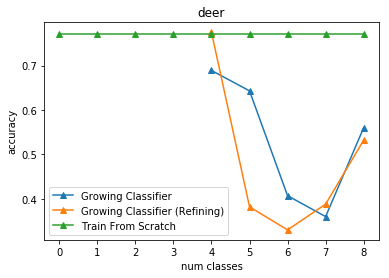

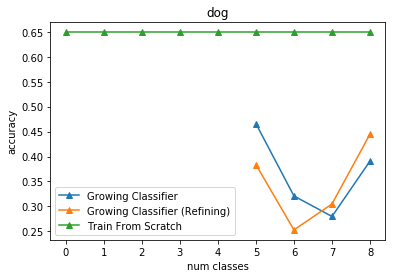

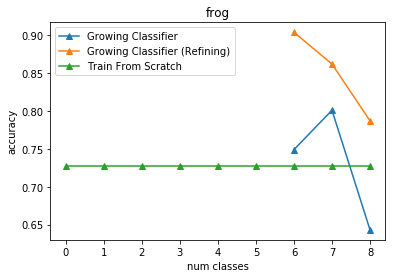

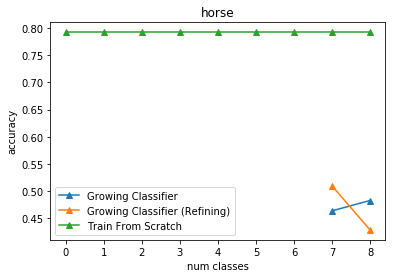

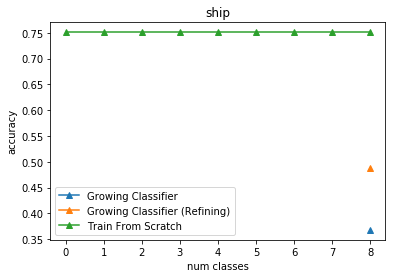

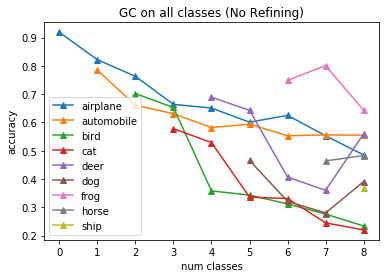

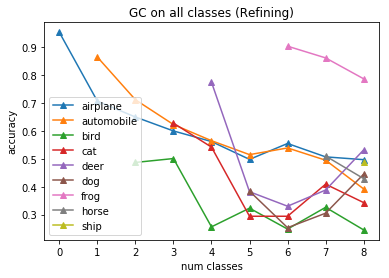

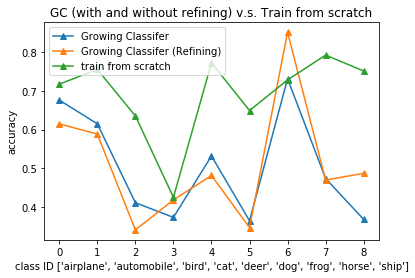

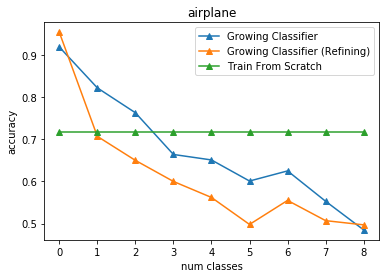

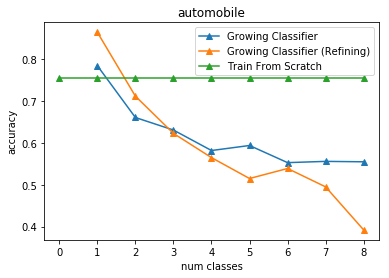

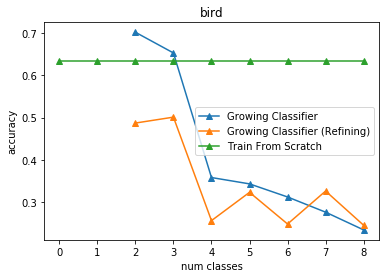

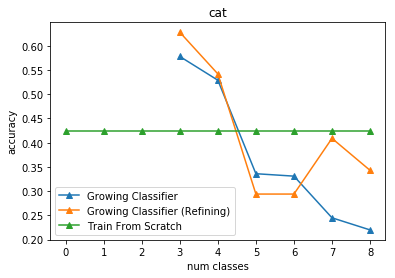

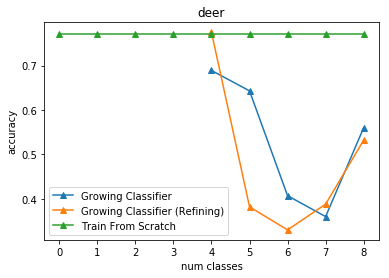

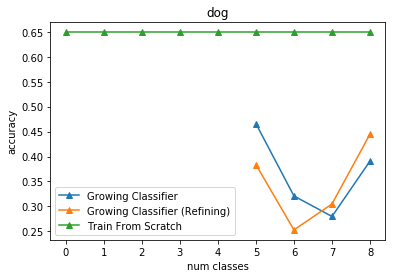

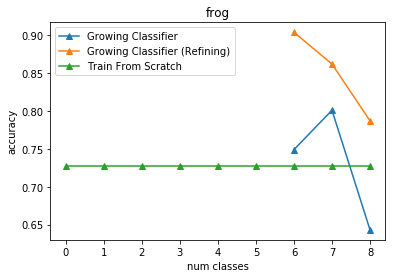

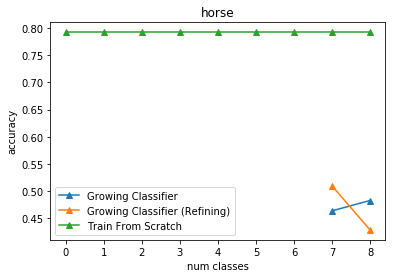

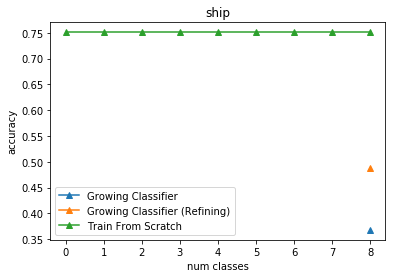

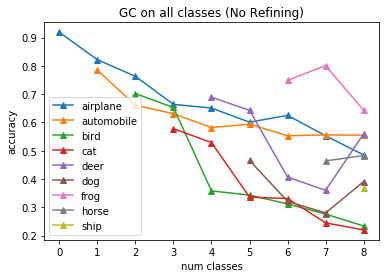

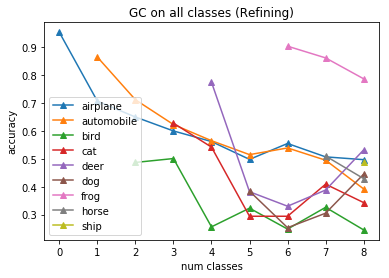

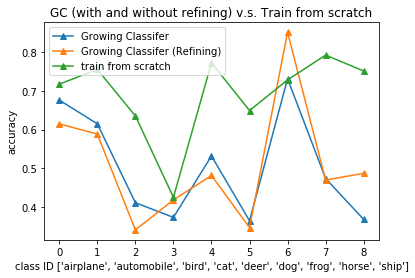

In [41]:

GC_refining_results = []
GC_results = []
from_scratch_result, GC_refining_result, GC_result = one_run1(model, x_train, y_train, 
                                            x_test, y_test, batch_size, full_target_class_ids, 
                                              base_epochs, class_names,initial_weights,datagen)
GC_refining_results += [GC_refining_result]
GC_results += [GC_result]

plot_result(from_scratch_result, GC_result, GC_refining_result, full_target_class_ids, 
                            class_names)



======Training From Scratch=========

[22378 28352  3874 47169 15297 14832 43583 22769  9552 43399]
current other class: [10]
current target class: [1 9 5 4 7 2 6 3 8]
all target target class: [1, 9, 5, 4, 7, 2, 6, 3, 8]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 5000
(45000,) (5000,)
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
50000/50000 [==============================] - 13s 259us/step - loss: 1.3921 - acc: 0.5691
Epoch 2/30
50000/50000 [==============================] - 11s 229us/step - loss: 0.8585 - acc: 0.7354
Epoch 3/30
50000/50000 [==============================] - 11s 229us/step - loss: 0.6711 - acc: 0.8032
Epoch 4/30
50000/50000 [==============================] - 11s 230us/step - loss: 0.5627 - acc: 0.8442
Epoch 5/30
50000/50000 [==============================] - 12s 230us/step - loss: 0.4908 - acc: 0.8693
Epoch 6/30
50000/50000 [==============================] - 11s 230us/step - loss: 0.4571 - acc: 0.8848
Epoch 7/30
50000/50000 [====

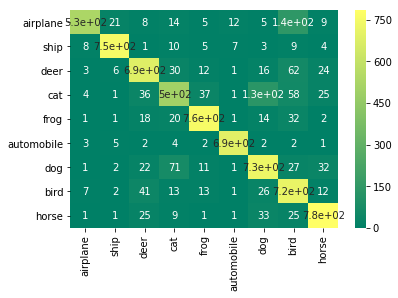


=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

[26493 24679 45393 48729   905 40542   352 17396 16952 22951]
current other class: [ 2  3  4  5  6  7  8  9 10]
current target class: [1]
all target target class: [1, 9, 5, 4, 7, 2, 6, 3, 8]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 5000
(5000,) (5000,)
Epoch 1/30
10000/10000 [==============================] - 3s 316us/step - loss: 8.1004 - acc: 0.4943
Epoch 2/30
10000/10000 [==============================] - 2s 228us/step - loss: 3.5155 - acc: 0.7771
Epoch 3/30
10000/10000 [==============================] - 2s 224us/step - loss: 0.5184 - acc: 0.9591
Epoch 4/30
10000/10000 [==============================] - 2s 223us/step - loss: 0.4075 - acc: 0.9695
Epoch 5/30
10000/10000 [==============================] - 2s 225us/step - loss: 0.3792 - acc: 0.9708
Epoch 6/30
10000/10000 [==============================] - 2s 224us/step - loss: 0.3694 - acc: 0.9703
Epoch 7/30
10000/10

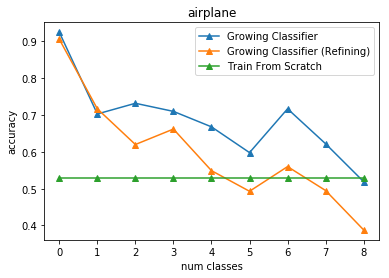

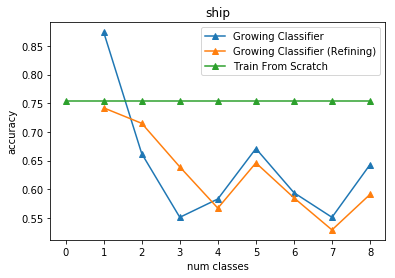

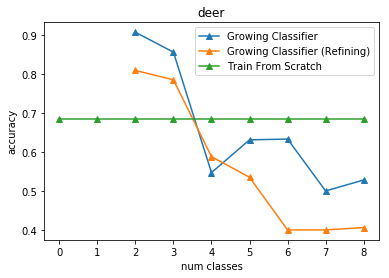

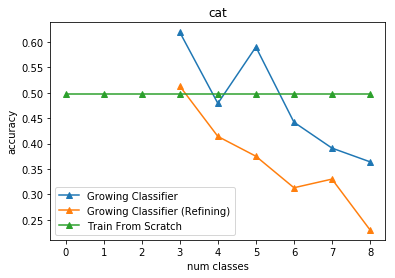

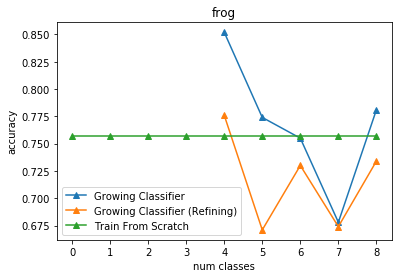

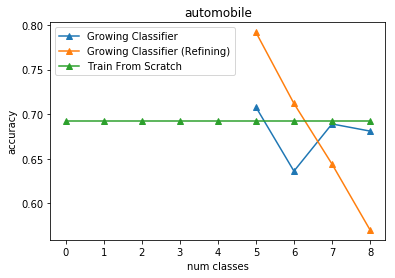

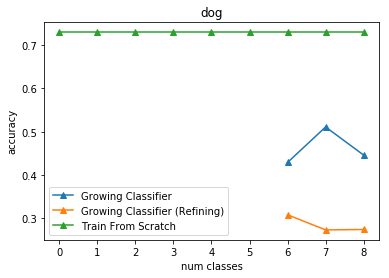

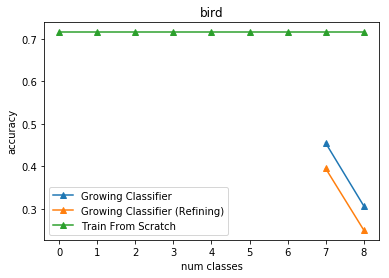

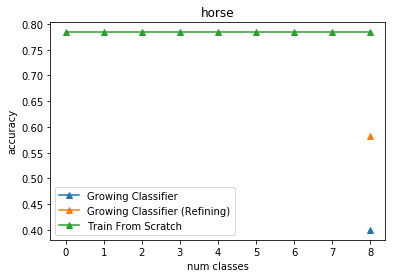

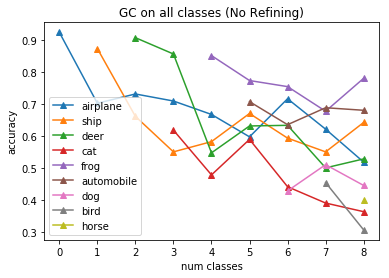

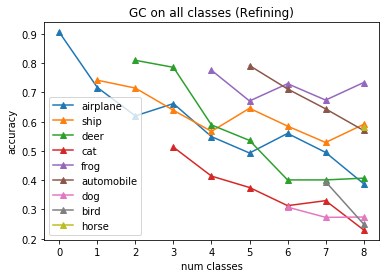

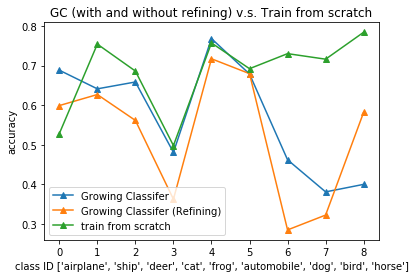

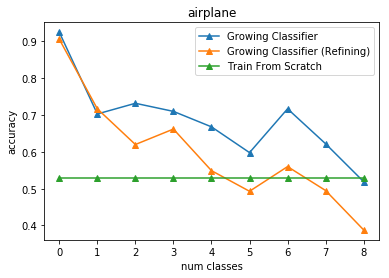

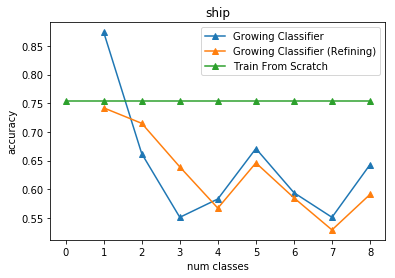

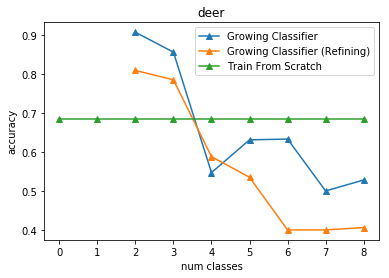

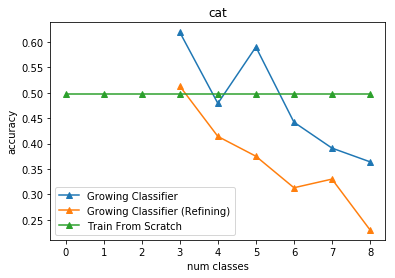

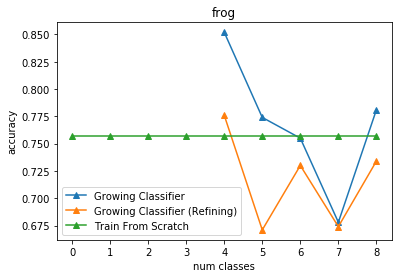

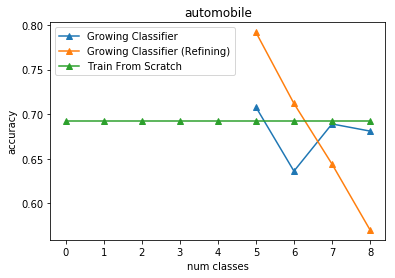

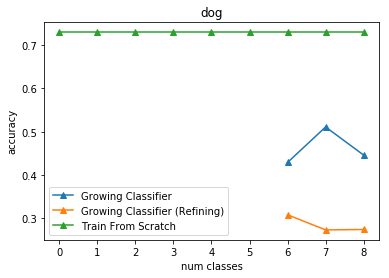

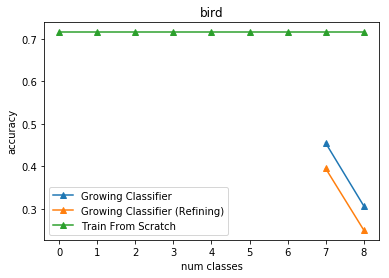

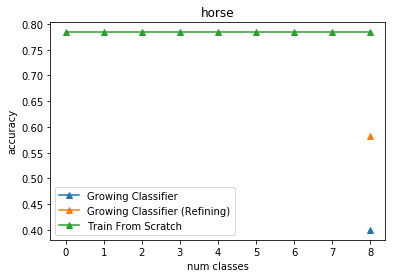

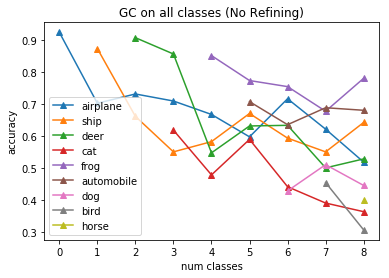

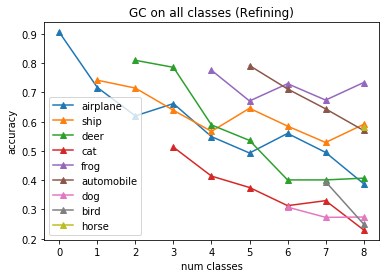

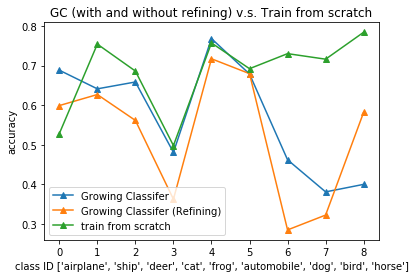

In [11]:

GC_refining_results = []
GC_results = []
from_scratch_result, GC_refining_result, GC_result = one_run1(model, x_train, y_train, 
                                            x_test, y_test, batch_size, full_target_class_ids, 
                                              base_epochs, class_names,initial_weights,datagen)
GC_refining_results += [GC_refining_result]
GC_results += [GC_result]

plot_result(from_scratch_result, GC_result, GC_refining_result, full_target_class_ids, 
                            class_names)



======Training From Scratch=========

[22215 28854  4332 47303 15618 15299 43962 22769  9599 42888]
current other class: [8]
current target class: [ 1  2  3  4  5  6  7  9 10]
all target target class: [1, 2, 3, 4, 5, 6, 7, 9, 10]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 5000
(45000,) (5000,)
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
50000/50000 [==============================] - 13s 261us/step - loss: 1.4034 - acc: 0.5609
Epoch 2/30
50000/50000 [==============================] - 12s 230us/step - loss: 0.8594 - acc: 0.7335
Epoch 3/30
50000/50000 [==============================] - 12s 231us/step - loss: 0.6767 - acc: 0.7974
Epoch 4/30
50000/50000 [==============================] - 12s 231us/step - loss: 0.5716 - acc: 0.8389
Epoch 5/30
50000/50000 [==============================] - 12s 240us/step - loss: 0.5007 - acc: 0.8636
Epoch 6/30
50000/50000 [==============================] - 12s 235us/step - loss: 0.4543 - acc: 0.8844
Epoch 7/30
50000/50

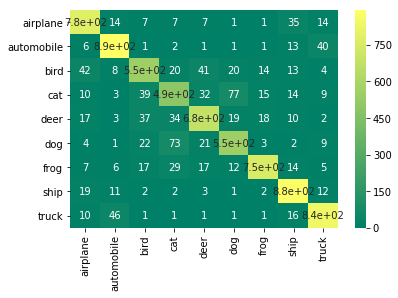


=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

[26493 24679 45393 48729   905 40542   352 17396 16952 22951]
current other class: [ 2  3  4  5  6  7  8  9 10]
current target class: [1]
all target target class: [1, 2, 3, 4, 5, 6, 7, 9, 10]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 5000
(5000,) (5000,)
Epoch 1/30
10000/10000 [==============================] - 3s 321us/step - loss: 8.1004 - acc: 0.4943
Epoch 2/30
10000/10000 [==============================] - 2s 230us/step - loss: 3.5156 - acc: 0.7772
Epoch 3/30
10000/10000 [==============================] - 2s 228us/step - loss: 0.5257 - acc: 0.9565
Epoch 4/30
10000/10000 [==============================] - 2s 228us/step - loss: 0.4084 - acc: 0.9669
Epoch 5/30
10000/10000 [==============================] - 2s 228us/step - loss: 0.3967 - acc: 0.9715
Epoch 6/30
10000/10000 [==============================] - 2s 228us/step - loss: 0.3798 - acc: 0.9706
Epoch 7/30
10000/1

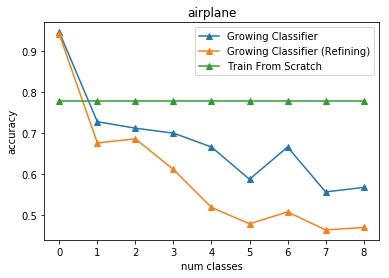

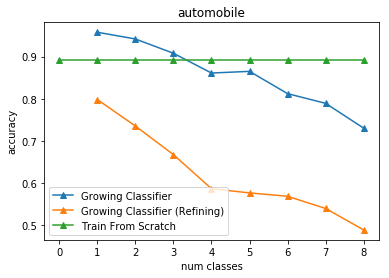

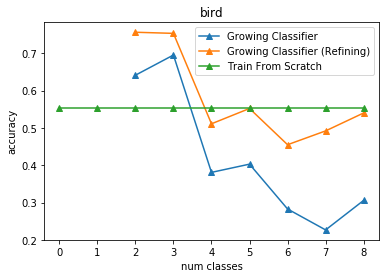

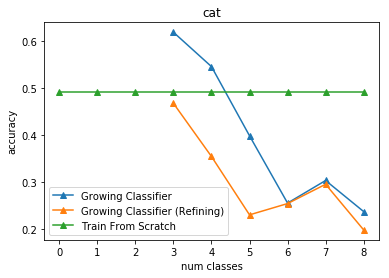

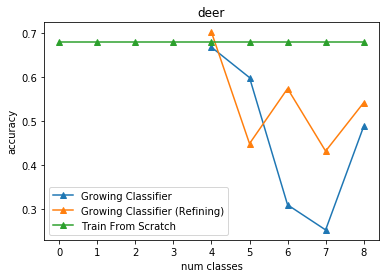

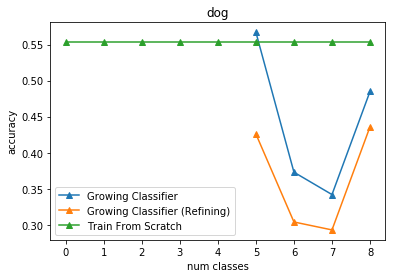

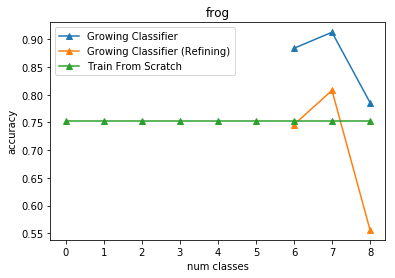

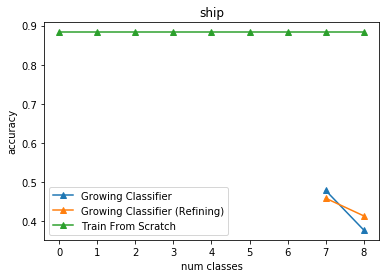

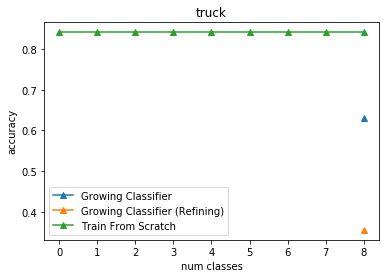

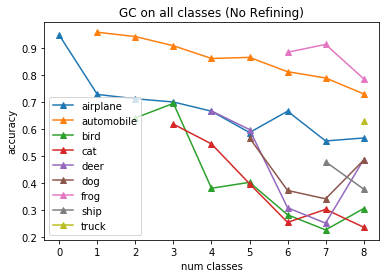

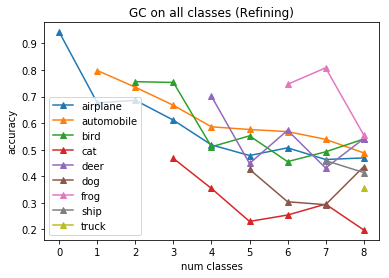

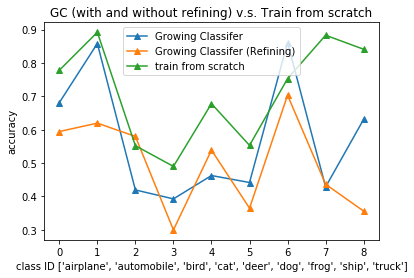

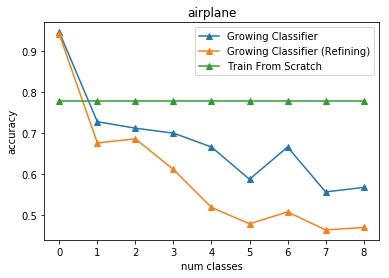

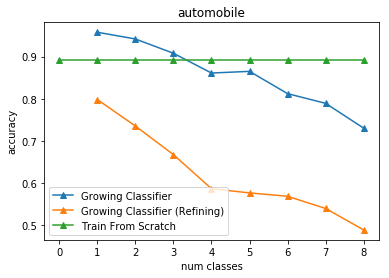

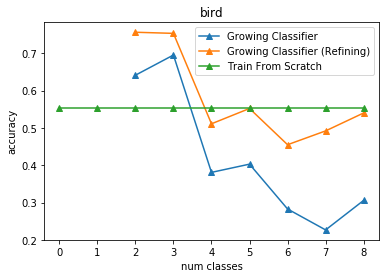

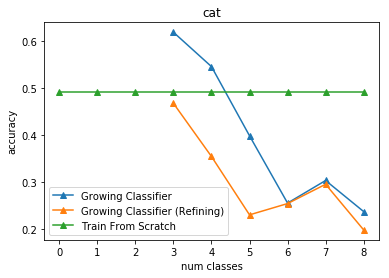

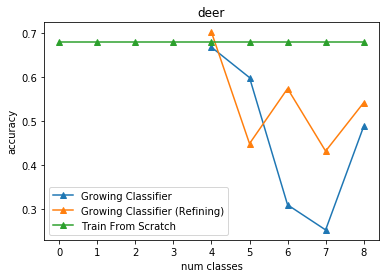

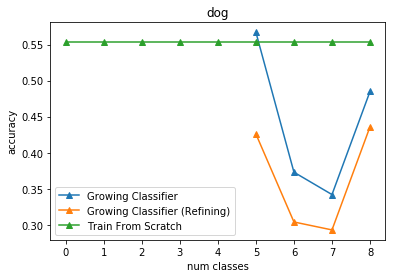

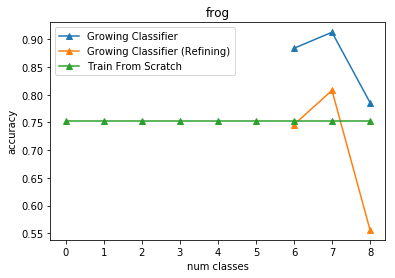

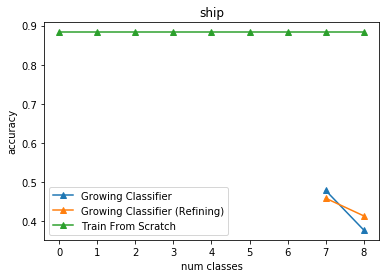

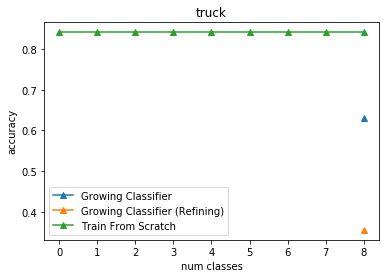

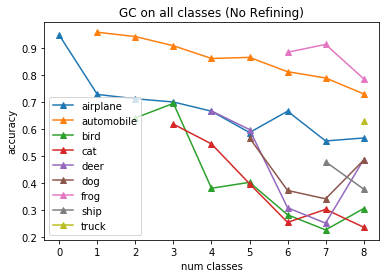

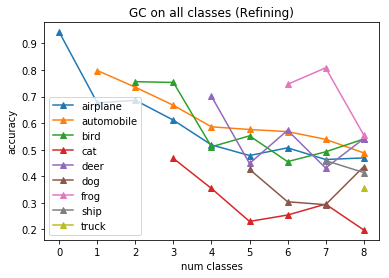

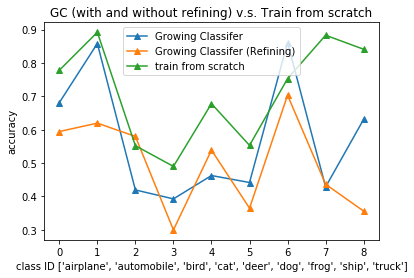

In [11]:

GC_refining_results = []
GC_results = []
from_scratch_result, GC_refining_result, GC_result = one_run1(model, x_train, y_train, 
                                            x_test, y_test, batch_size, full_target_class_ids, 
                                              base_epochs, class_names,initial_weights,datagen)
GC_refining_results += [GC_refining_result]
GC_results += [GC_result]

plot_result(from_scratch_result, GC_result, GC_refining_result, full_target_class_ids, 
                            class_names)


======Training From Scratch=========

[22378 28352  3874 47016 16610 14832 43583 22769 10556 43218]
current other class: [8]
current target class: [ 1  9  5  4  7  2 10  6  3]
all target target class: [1, 9, 5, 4, 7, 2, 10, 6, 3]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 5000
(45000,) (5000,)
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
50000/50000 [==============================] - 14s 285us/step - loss: 1.3359 - acc: 0.5788
Epoch 2/30
50000/50000 [==============================] - 12s 232us/step - loss: 0.8110 - acc: 0.7479
Epoch 3/30
50000/50000 [==============================] - 11s 229us/step - loss: 0.6406 - acc: 0.8102
Epoch 4/30
50000/50000 [==============================] - 11s 230us/step - loss: 0.5329 - acc: 0.8499
Epoch 5/30
50000/50000 [==============================] - 11s 229us/step - loss: 0.4720 - acc: 0.8743
Epoch 6/30
50000/50000 [==============================] - 11s 229us/step - loss: 0.4199 - acc: 0.8937
Epoch 7/30
50000/50

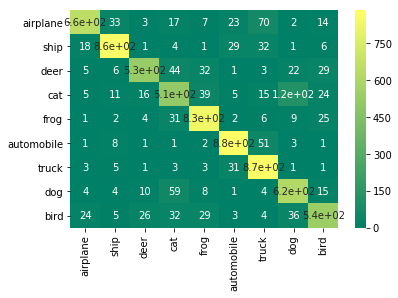


=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

[26493 24679 45393 48729   905 40542   352 17396 16952 22951]
current other class: [ 2  3  4  5  6  7  8  9 10]
current target class: [1]
all target target class: [1, 9, 5, 4, 7, 2, 10, 6, 3]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 5000
(5000,) (5000,)
Epoch 1/30
10000/10000 [==============================] - 3s 320us/step - loss: 8.1004 - acc: 0.4943
Epoch 2/30
10000/10000 [==============================] - 2s 229us/step - loss: 3.5266 - acc: 0.7765
Epoch 3/30
10000/10000 [==============================] - 2s 228us/step - loss: 0.5149 - acc: 0.9606
Epoch 4/30
10000/10000 [==============================] - 2s 226us/step - loss: 0.4361 - acc: 0.9629
Epoch 5/30
10000/10000 [==============================] - 2s 223us/step - loss: 0.4292 - acc: 0.9633
Epoch 6/30
10000/10000 [==============================] - 2s 227us/step - loss: 0.3435 - acc: 0.9696
Epoch 7/30
10000/1

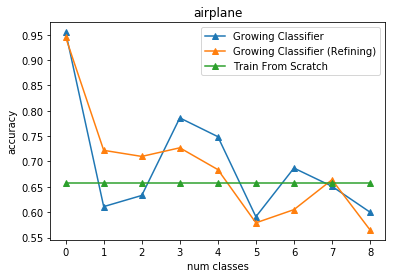

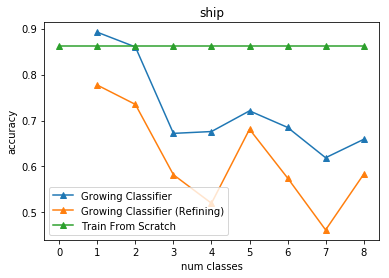

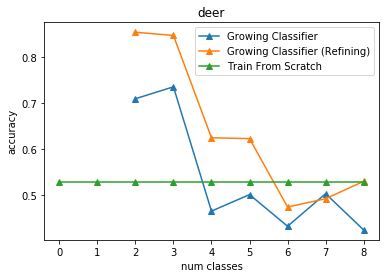

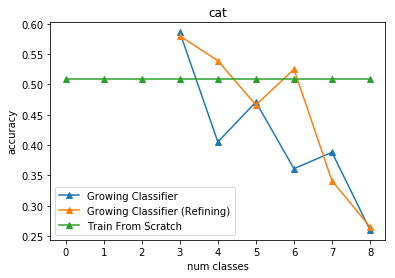

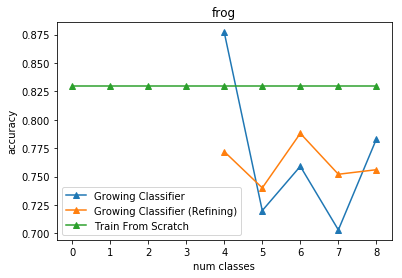

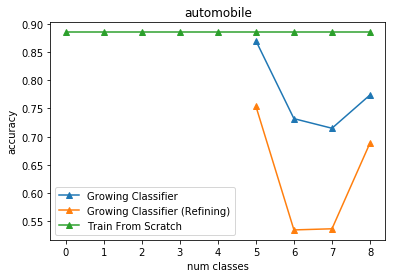

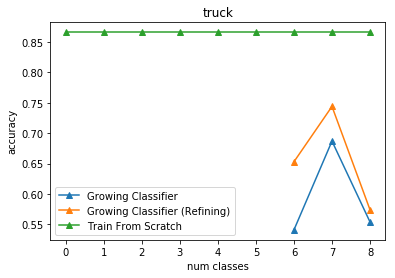

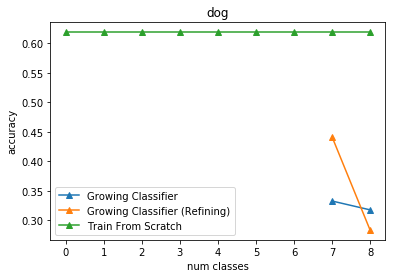

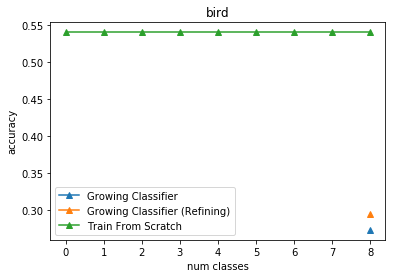

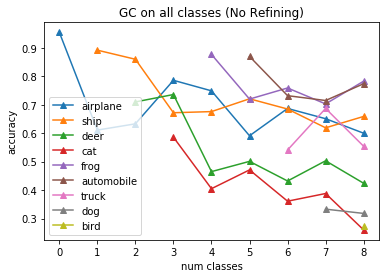

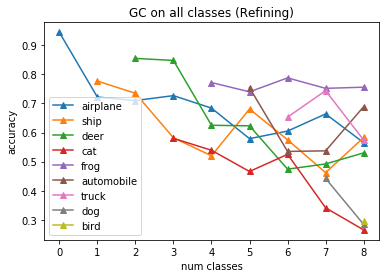

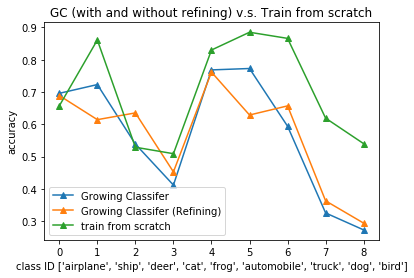

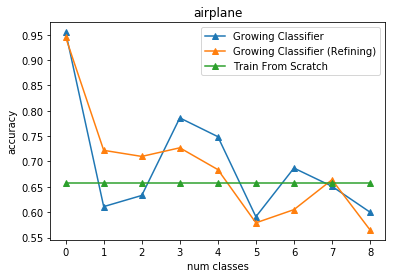

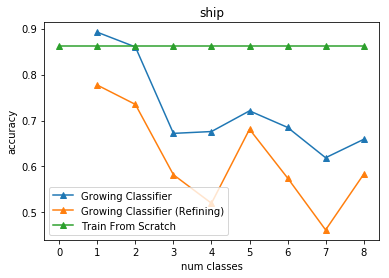

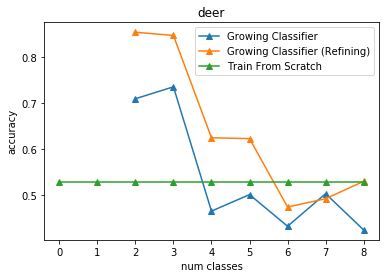

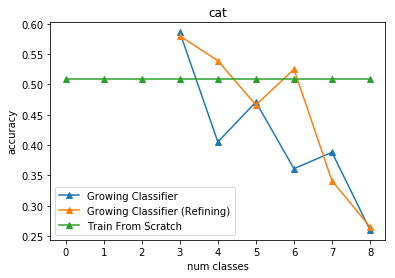

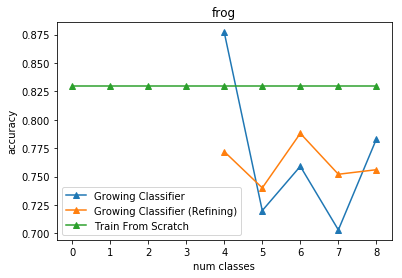

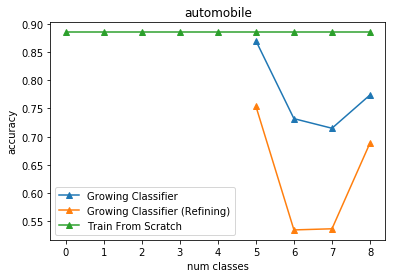

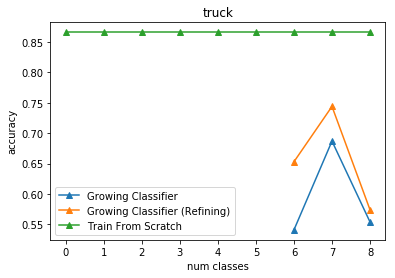

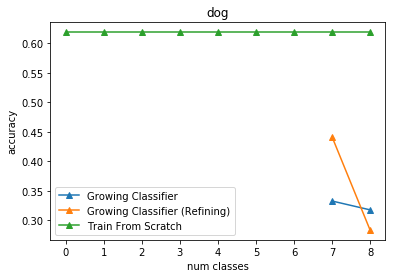

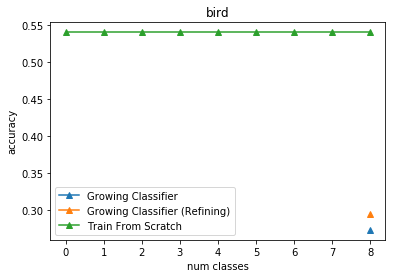

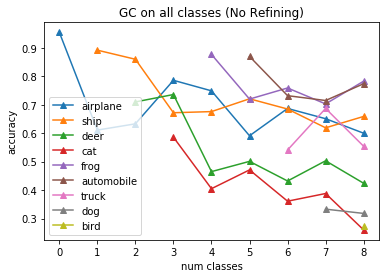

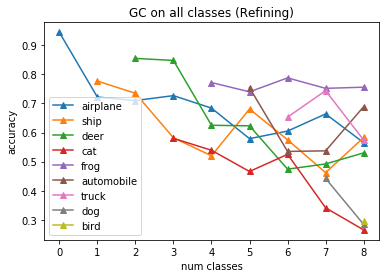

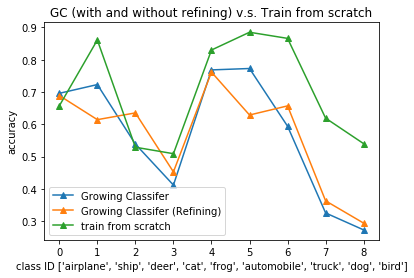

In [11]:

GC_refining_results = []
GC_results = []
from_scratch_result, GC_refining_result, GC_result = one_run1(model, x_train, y_train, 
                                            x_test, y_test, batch_size, full_target_class_ids, 
                                              base_epochs, class_names,initial_weights,datagen)
GC_refining_results += [GC_refining_result]
GC_results += [GC_result]

plot_result(from_scratch_result, GC_result, GC_refining_result, full_target_class_ids, 
                            class_names)


======Training From Scratch=========

[22802 28854  3874 46851 15338 14832 43962 22769  9625 42717]
current other class: [8]
current target class: [ 1  9 10  2  4  6  3  7  5]
all target target class: [1, 9, 10, 2, 4, 6, 3, 7, 5]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 5000
(45000,) (5000,)
Epoch 1/30
50000/50000 [==============================] - 19s 379us/step - loss: 1.3359 - acc: 0.5742
Epoch 2/30
50000/50000 [==============================] - 12s 243us/step - loss: 0.8301 - acc: 0.7437
Epoch 3/30
50000/50000 [==============================] - 12s 243us/step - loss: 0.6621 - acc: 0.8070
Epoch 4/30
50000/50000 [==============================] - 12s 245us/step - loss: 0.5431 - acc: 0.8479
Epoch 5/30
50000/50000 [==============================] - 12s 246us/step - loss: 0.4772 - acc: 0.8726
Epoch 6/30
50000/50000 [==============================] - 12s 246us/step - loss: 0.4319 - acc: 0.8911
Epoch 7/30
50000/50000 [==============================] - 12s 247us

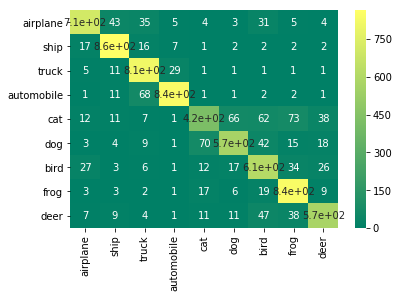


=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

[26493 24679 45393 48729   905 40542   352 17396 16952 22951]
current other class: [ 2  3  4  5  6  7  8  9 10]
current target class: [1]
all target target class: [1, 9, 10, 2, 4, 6, 3, 7, 5]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 5000
(5000,) (5000,)
Epoch 1/30
10000/10000 [==============================] - 9s 918us/step - loss: 8.1004 - acc: 0.4943
Epoch 2/30
10000/10000 [==============================] - 2s 238us/step - loss: 3.5266 - acc: 0.7765
Epoch 3/30
10000/10000 [==============================] - 2s 242us/step - loss: 0.5497 - acc: 0.9599
Epoch 4/30
10000/10000 [==============================] - 2s 238us/step - loss: 0.4506 - acc: 0.9675
Epoch 5/30
10000/10000 [==============================] - 2s 238us/step - loss: 0.4075 - acc: 0.9714
Epoch 6/30
10000/10000 [==============================] - 2s 238us/step - loss: 0.3785 - acc: 0.9696
Epoch 7/30
10000/1

In [29]:
#semantic similarity

GC_refining_results = []
GC_results = []
from_scratch_result, GC_refining_result = one_run1(model, x_train, y_train, 
                                            x_test, y_test, batch_size, full_target_class_ids, 
                                              base_epochs, class_names,initial_weights,datagen)
GC_refining_results += [GC_refining_result]





=====Training Using Growing Classifier (new classes never appeared in 'Other' class before) ======

[26493 24679 45393 48729   905 40542   352 17396 16952 22951]
current other class: [8]
current target class: [1]
all target target class: [1, 9, 10, 2, 4, 6, 3, 7, 5]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 5000
(5000,) (5000,)
Epoch 1/30
10000/10000 [==============================] - 11s 1ms/step - loss: 8.1010 - acc: 0.4944
Epoch 2/30
10000/10000 [==============================] - 3s 251us/step - loss: 4.3276 - acc: 0.7259
Epoch 3/30
10000/10000 [==============================] - 3s 252us/step - loss: 0.4993 - acc: 0.9598
Epoch 4/30
10000/10000 [==============================] - 3s 253us/step - loss: 0.5149 - acc: 0.9607
Epoch 5/30
10000/10000 [==============================] - 2s 248us/step - loss: 0.3810 - acc: 0.9606
Epoch 6/30
10000/10000 [==============================] - 3s 253us/step - loss: 0.3711 - acc: 0.9720
Epoch 7/30
10000/10000 [==============

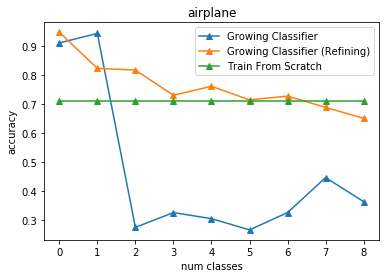

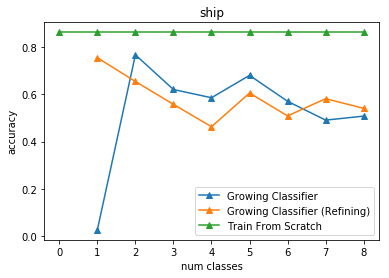

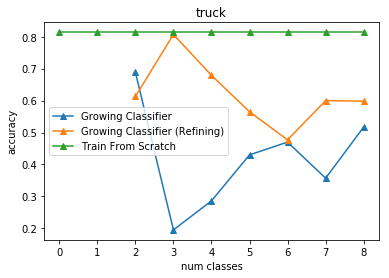

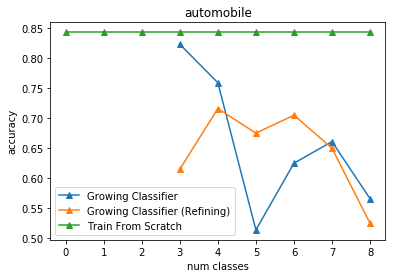

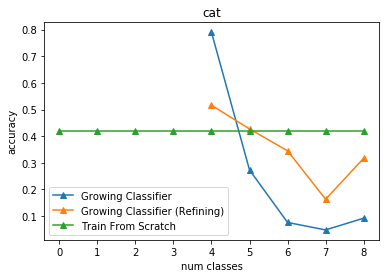

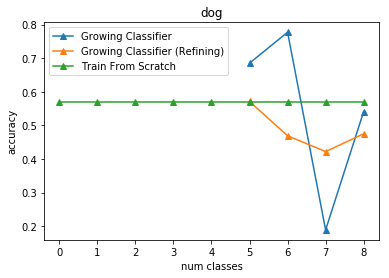

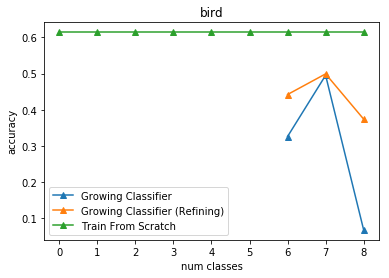

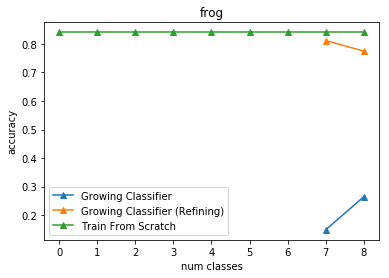

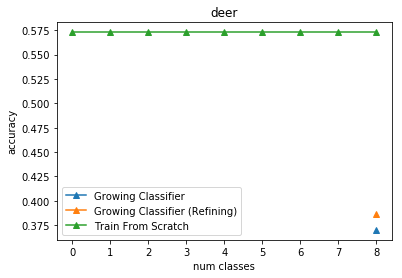

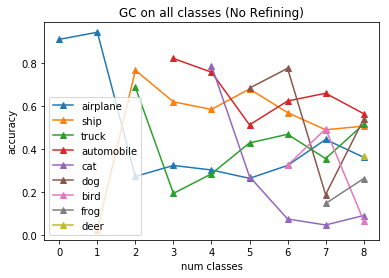

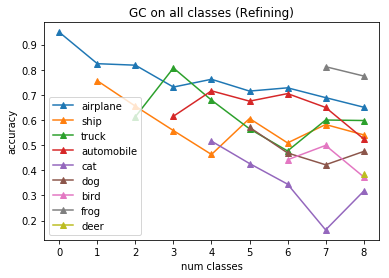

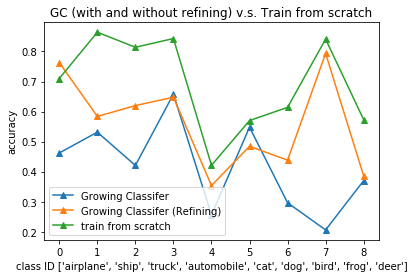

In [30]:
print('\n=====Training Using Growing Classifier (new classes never appeared in \'Other\' class before) ======\n')
weights_growing_classifier = list(initial_weights)
     # use the same initial weights
model.set_weights(weights_growing_classifier)

for layer in model.layers: layer.trainable = True

acc_GC, loss_GC = training_with_GC(model, full_target_class_ids, base_epochs, 
                                                    x_train, y_train, x_test, y_test, 
                                                     datagen, batch_size, False)
    
print(acc_GC)

GC_results += [GC_result]
plot_result(from_scratch_result, GC_result, GC_refining_result, full_target_class_ids, 
                            class_names)


In [ ]:
plot_result(acc_all_class_from_scratch, acc_GC, acc_GC_refining, full_target_class_ids, class_names)